## Data Selection

**Input**: 

- (All) Gaia DR3 stars pre-selected for the local 50-pc sphere with deblended G-RP color 

- Gaia catalog of white dwarfs by Fusillo+21, GCWD21, 
with new 33 local objects as identified by Golovin+24 and deblended G-RP color 

**Method**:

### Selection criteria

##### For WD sample:
- Probability_WD > 0.5 (loose cut) 

##### For Gaia DR3 sample:
- $\mathrm{astrometric\_gof\_harmonic\_amplitude} < 10^{-5.12} \times (\mathrm{parallax}/\mathrm{parallax\_error})^{2.61}$ (following Golovin23)

- Cut to separate MS from WD: \
$(G - G\_RP) > 1.2$,  
$(G - G\_RP) <= 1.2  \ \&  \ M\_G < 4.8*(G - G\_RP) + 9.5$

- Remove WD-sample dublicates 

### Volume definition

We do not apply exact cut on 1/parallax, but calculate probabilities for all stars to have parallax > 20 mas (50 pc). These weights are later used to construct Hess diagram. 

**Output**: 

GCWD sample and pre-selected 50-pc MS (and some giants) sample with new columns: 
- P(parallax > 20 mas|parallax,parallax_error) column
- distance (1/parallax, pc)
- M_G, mag

In [1]:
import numpy as np
import scipy.stats as stats
from astropy.table import Table, vstack

import matplotlib.pyplot as plt

In [2]:
def prob_greater_than(X1, X0, sigma_X):
    """
    Compute P(X > X1) for a normal distribution N(X0, sigma_X^2).
    """
    z = (X1 - X0) / sigma_X
    return 1 - stats.norm.cdf(z)

In [14]:
def process_wd(data,r):

    # Read WD sample - joined GFWD21+Golovin24 catalog based on Gaia EDR3 and DR3 
    table_wd = Table.read(data)

    table_wd['d'] = 1000/table_wd['Plx']
    table_wd['M_G'] = table_wd['Gmag'] - 5*np.log10(table_wd['d']) + 5

    print('Number WD stars in raw sample: ',len(table_wd['d']))

    table_wd = table_wd[np.logical_and.reduce([table_wd['Pwd'] > 0.75])]
    print('High-probability WD: ',len(table_wd['d']))

    # Sharp cut on distance
    #table_wd = table_wd[np.logical_and.reduce([table_wd['d'] < r])] 
    #print('Within volume: ',len(table_wd['d']))

    # Probability to belong to the volume
    table_wd['weights'] = [prob_greater_than(1000/r, par, epar) for par, epar in zip(table_wd['Plx'],
                                                                                    table_wd['e_Plx'])]
    print('Within volume: ',int(round(sum(table_wd['weights']),0)))

    filename = data.split('.')[0] + '_w.csv'
    table_wd.write(filename, overwrite=True)
    print('Saved to ',filename)

    return table_wd


In [15]:
def process_ms(data,r,table_wd):
    
    # Read Gaia DR3 data pre-selected for 50 pc sphere 
    # (parallax + 3*parallax error > 20 mas)

    table_gaia = Table.read(data)

    # Calculate distance and absolute G
    table_gaia['d'] = 1000/table_gaia['parallax']
    table_gaia['M_G'] = table_gaia['phot_g_mean_mag'] - 5*np.log10(table_gaia['d']) + 5

    print('Number Gaia stars in raw sample: ',len(table_gaia['d']))

    # With this selection no additional cuts on astrometric_excess_noise and its sigma are needed!
    table_gaia =\
        table_gaia[np.logical_and.reduce(
            [table_gaia['ipd_gof_harmonic_amplitude'] <\
             10**(-5.12)*(table_gaia['parallax']/table_gaia['parallax_error'])**2.61])]
    print('Good astrometry: ',len(table_gaia['d']))

    table_gaia = table_gaia[np.logical_and.reduce([table_gaia['phot_g_mean_mag'].filled(-999) != -999])]
    print('Known photometry: ',len(table_gaia['d']))

    # Separate MS
    table_ms1 = table_gaia[np.logical_and.reduce([table_gaia['g_rp_deblended'] > 1.2])]
    table_ms2 = table_gaia[np.logical_and.reduce(
        [table_gaia['g_rp_deblended'] <= 1.2,
         table_gaia['M_G'] < 4.8*table_gaia['g_rp_deblended'] + 9.5])]
    table_ms = vstack([table_ms1, table_ms2])
    print('Only MS: ',len(table_ms['d']))

    # Sharp cut on distance
    #table_gaia = table_gaia[np.logical_and.reduce([table_gaia['d'] < r])]
    #print('Within volume: ',len(table_gaia['d']))

    # Probability to belong to the volume
    table_ms['weights'] =\
        [prob_greater_than(1000/r, par, epar) for par, epar in zip(table_ms['parallax'],
                                                                   table_ms['parallax_error'])]
    print('Within volume: ',int(round(sum(table_ms['weights']),0)))

    # Remove dublicates (to make sure no stars entered the sample twice)
    ms_mask = [gaia_id in table_wd['GDR3_id'] for gaia_id in table_ms['source_id']]
    table_ms['weights'][ms_mask] = 0 
    print('Removed WD duplicates: ',int(round(sum(table_ms['weights']),0)))

    filename = data.split('.')[0] + '_w.csv'
    table_ms.write(filename, overwrite=True)
    print('Saved to ',filename)

    return table_ms



In [5]:
# Size of the local sphere
r = 50  # pc

In [16]:
data = 'data/GCWD21+Golovin24_source_deblended.csv'
table_wd = process_wd(data,r)

Number WD stars in raw sample:  1280296
High-probability WD:  359073
Within volume:  2133
Saved to  data/GCWD21+Golovin24_source_deblended_w.csv


In [17]:
data = 'data/GDR3_50pc_preselection_source_deblended.csv'
table_ms = process_ms(data,r,table_wd)

Number Gaia stars in raw sample:  107487
Good astrometry:  41207
Known photometry:  41157
Only MS:  38142
Within volume:  36999
Removed WD duplicates:  36999
Saved to  data/GDR3_50pc_preselection_source_deblended_w.csv


In [ ]:
n_ms = int(round(sum(table_ms['weights']),0))
n_wd = int(round(sum(table_wd['weights']),0))
print('Total: ', n_ms + n_wd)

Total:  39140


Text(0, 0.5, 'M_G')

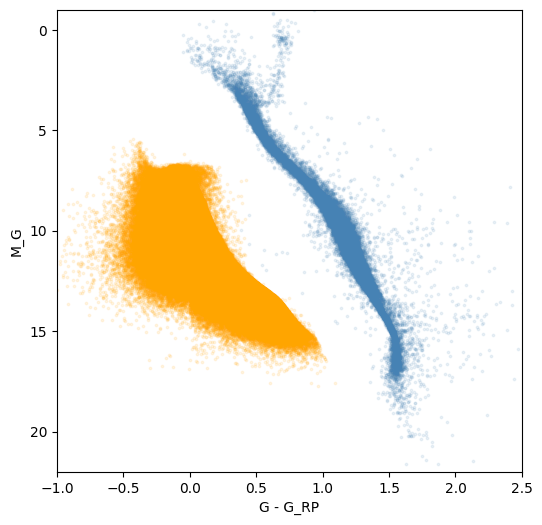

In [ ]:
# Simple illustration

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(table_ms['g_rp_deblended'],table_ms['M_G'],
           c='steelblue',alpha=0.1,s=3)
ax.scatter(table_wd['g_rp_deblended'],table_wd['M_G'],
           c='orange',alpha=0.1,s=3)
ax.set_ylim(22,-1)
ax.set_xlim(-1,2.5)
ax.set_xlabel('G - G_RP')
ax.set_ylabel('M_G')